<a href="https://colab.research.google.com/github/somilvasal/Covid-AI/blob/main/Copy_of_Training_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## importing necessary libraries

In [ ]:
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50, InceptionV3, Xception
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import cv2
import os

print('Library Importing Complete')

Library Importing Complete


## Loading data

In [ ]:
!git clone https://github.com/Rajsoni03/MyData.git

Cloning into 'MyData'...
remote: Enumerating objects: 7250, done.
remote: Total 7250 (delta 0), reused 0 (delta 0), pack-reused 7250
Receiving objects: 100% (7250/7250), 524.06 MiB | 20.53 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (7261/7261), done.


In [ ]:
data_path = '/content/MyData/data'

print("loading images", end='')
imagePaths = list(paths.list_images(data_path))
print(f' : {len(imagePaths)} images in data directory')
data, labels = [], []

_C, _N, _P = 1,1,1


# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if label == 'covid' and _C <= 70:        # importing 700 Covid CRX images
      data.append(image)
      labels.append(label)
      _C += 1
    if label == 'normal' and _N <= 215:      # importing 2150 Normal CRX images
      data.append(image)
      labels.append(label)
      _N += 1
    if label == 'pneumonia' and _P <= 215:   # importing 2150 Pneumonia CRX images
      data.append(image)
      labels.append(label)
      _P += 1


data = np.array(data) / 255.0
labels = np.array(labels)

print('encoding the labels')
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# labels = to_categorical(labels) # for 2 classes

print(f"Total {len(data)} images are loaded")
print(f"Data Shape : {data.shape} \nLebals Shape : {labels.shape}")

loading images : 7256 images in data directory
encoding the labels
Total 500 images are loaded
Data Shape : (500, 224, 224, 3) 
Lebals Shape : (500, 3)


## Split data into Training / Validation / Testing set

In [ ]:
trainX, tempX, trainY, tempY = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=5)

testX, valX, testY, valY = train_test_split(tempX, tempY, test_size=0.5, random_state=5)

print(f'Training Images: {trainX.shape[0]} \nTesting Images: {testX.shape[0]} \nValidation Images: {valX.shape[0]}')

Training Images: 400 
Testing Images: 50 
Validation Images: 50


## Creating Models

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

def finalLayers(baseModel):
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(128, activation="relu")(headModel)
  # headModel = Dropout(rate=0.8)(headModel)  
  headModel = Dense(3, activation="softmax")(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)
  
  # All layers be updated during the training process
  for layer in baseModel.layers:
    layer.trainable = True
  return model

# load CNN networks
VGG16_model = finalLayers(VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))))
DenseNet121_model = finalLayers(DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))))
ResNet50_model = finalLayers(ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))))
InceptionV3_model = finalLayers(InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))))
Xception_model = finalLayers(Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))))

print('Models Are Ready')

83689472/83683744 [==============================] - 1s 0us/step
Models Are Ready


## Setup Hyperparameters

In [ ]:
INIT_LR = 1e-3
EPOCHS = 30
BS = 16

print('Done..')

Done..


## Compiling the models with ADAM optimizer

In [ ]:
print("compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

VGG16_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
DenseNet121_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
ResNet50_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
InceptionV3_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
Xception_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print('Compiling Completed')

compiling model...
Compiling Completed


## Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/Covid Thesis/logs'

## Train VGG16 Model

In [ ]:
# tensorboard setup
name = 'VGG16_v2.0'

NAME = '{}-{}'.format(name, int(time.time()))
tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/Covid Thesis/logs/{}'.format(NAME))

# train the head of the network
print("training the VGG16 model...")
VGG16_H = VGG16_model.fit(trainAug.flow(trainX, trainY, batch_size=BS),
                          steps_per_epoch=len(trainX) // BS,
                          validation_data=(valX, valY),
                          validation_steps=len(valX) // BS,
                          epochs=EPOCHS,
                          callbacks=[tensorboard])
# Save the model
VGG16_model.save('/content/drive/MyDrive/Covid Thesis/models/{}.h5'.format(name))
pd.DataFrame(VGG16_H.history).to_csv('/content/drive/MyDrive/Covid Thesis/History/{}.csv'.format(name))

training the VGG16 model...
Epoch 1/30
25/25 [==============================] - 13s 194ms/step - loss: 1.7292 - accuracy: 0.4914 - val_loss: 0.9796 - val_accuracy: 0.3800
Epoch 2/30
25/25 [==============================] - 4s 154ms/step - loss: 1.0308 - accuracy: 0.4186 - val_loss: 0.9725 - val_accuracy: 0.5000
Epoch 3/30
25/25 [==============================] - 4s 155ms/step - loss: 1.0030 - accuracy: 0.4805 - val_loss: 0.9667 - val_accuracy: 0.5000
Epoch 4/30
25/25 [==============================] - 4s 154ms/step - loss: 0.9966 - accuracy: 0.4506 - val_loss: 0.9046 - val_accuracy: 0.7000
Epoch 5/30
25/25 [==============================] - 4s 154ms/step - loss: 0.9712 - accuracy: 0.5423 - val_loss: 1.0015 - val_accuracy: 0.3800
Epoch 6/30
25/25 [==============================] - 4s 153ms/step - loss: 1.0050 - accuracy: 0.5125 - val_loss: 0.9792 - val_accuracy: 0.4200
Epoch 7/30
25/25 [==============================] - 4s 158ms/step - loss: 1.0105 - accuracy: 0.5497 - val_loss: 1.1371 

## Train ResNet50 model 

In [ ]:
# tensorboard setup
name = 'ResNet50_v2.0'
NAME = '{}-{}'.format(name, int(time.time()))
tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/Covid Thesis/logs/{}'.format(NAME))

# train the head of the network
print("training the ResNet50 model...")
ResNet50_H = ResNet50_model.fit(trainAug.flow(trainX, trainY, batch_size=BS),
                          steps_per_epoch=len(trainX) // BS,
                          validation_data=(valX, valY),
                          validation_steps=len(valX) // BS,
                          epochs=EPOCHS,
                          callbacks=[tensorboard])
# Save the model
ResNet50_model.save('/content/drive/MyDrive/Covid Thesis/models/{}.h5'.format(name))
pd.DataFrame(ResNet50_H.history).to_csv('/content/drive/MyDrive/Covid Thesis/History/{}.csv'.format(name))

training the ResNet50 model...
Epoch 1/30
25/25 [==============================] - 10s 219ms/step - loss: 1.6326 - accuracy: 0.4115 - val_loss: 25302906437632.0000 - val_accuracy: 0.3800
Epoch 2/30
25/25 [==============================] - 4s 159ms/step - loss: 2.5757 - accuracy: 0.5180 - val_loss: 304537.0312 - val_accuracy: 0.5000
Epoch 3/30
25/25 [==============================] - 4s 156ms/step - loss: 0.8782 - accuracy: 0.5787 - val_loss: 784.6918 - val_accuracy: 0.5000
Epoch 4/30
25/25 [==============================] - 4s 158ms/step - loss: 0.8466 - accuracy: 0.5683 - val_loss: 1.0672 - val_accuracy: 0.5000
Epoch 5/30
25/25 [==============================] - 4s 155ms/step - loss: 0.7351 - accuracy: 0.6647 - val_loss: 1.0834 - val_accuracy: 0.5000
Epoch 6/30
25/25 [==============================] - 4s 153ms/step - loss: 0.5400 - accuracy: 0.7943 - val_loss: 1.0869 - val_accuracy: 0.5000
Epoch 7/30
25/25 [==============================] - 4s 156ms/step - loss: 0.5894 - accuracy: 0.7

## Train DenseNet121 model

In [ ]:
# tensorboard setup
name = 'DenseNet121_v2.0'
NAME = '{}-{}'.format(name, int(time.time()))
tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/Covid Thesis/logs/{}'.format(NAME))

# train the head of the network
print("training the DenseNet121 model...")
DenseNet121_H = DenseNet121_model.fit(trainAug.flow(trainX, trainY, batch_size=BS),
                          steps_per_epoch=len(trainX) // BS,
                          validation_data=(valX, valY),
                          validation_steps=len(valX) // BS,
                          epochs=EPOCHS,
                          callbacks=[tensorboard]
                          )
# Save the model
DenseNet121_model.save('/content/drive/MyDrive/Covid Thesis/models/{}.h5'.format(name))
pd.DataFrame(DenseNet121_H.history).to_csv('/content/drive/MyDrive/Covid Thesis/History/{}.csv'.format(name))

training the DenseNet121 model...
Epoch 1/30
25/25 [==============================] - 16s 281ms/step - loss: 1.5245 - accuracy: 0.5039 - val_loss: 9347661312294912.0000 - val_accuracy: 0.3800
Epoch 2/30
25/25 [==============================] - 4s 156ms/step - loss: 0.7337 - accuracy: 0.6862 - val_loss: 3816859136.0000 - val_accuracy: 0.3800
Epoch 3/30
25/25 [==============================] - 4s 156ms/step - loss: 0.5317 - accuracy: 0.7761 - val_loss: 2333972.7500 - val_accuracy: 0.3800
Epoch 4/30
25/25 [==============================] - 4s 156ms/step - loss: 0.4845 - accuracy: 0.8027 - val_loss: 31183.0254 - val_accuracy: 0.3200
Epoch 5/30
25/25 [==============================] - 4s 157ms/step - loss: 0.4647 - accuracy: 0.8534 - val_loss: 3371.4382 - val_accuracy: 0.3800
Epoch 6/30
25/25 [==============================] - 4s 154ms/step - loss: 0.3386 - accuracy: 0.8758 - val_loss: 22.9146 - val_accuracy: 0.5000
Epoch 7/30
25/25 [==============================] - 4s 157ms/step - loss: 0

RuntimeError: ignored

## Train InceptionV3 model

In [ ]:
# tensorboard setup
name = 'InceptionV3_v2.0'
NAME = '{}-{}'.format(name, int(time.time()))
tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/Covid Thesis/logs/{}'.format(NAME))

# train the head of the network
print("training the InceptionV3_model model...")
InceptionV3_H = InceptionV3_model.fit(trainAug.flow(trainX, trainY, batch_size=BS),
                          steps_per_epoch=len(trainX) // BS,
                          validation_data=(valX, valY),
                          validation_steps=len(valX) // BS,
                          epochs=EPOCHS,
                          callbacks=[tensorboard])
# Save the model
InceptionV3_model.save('/content/drive/MyDrive/Covid Thesis/models/{}.h5'.format(name))
pd.DataFrame(InceptionV3_H.history).to_csv('/content/drive/MyDrive/Covid Thesis/History/{}.csv'.format(name))

training the InceptionV3_model model...
Epoch 1/30
25/25 [==============================] - 12s 250ms/step - loss: 1.9564 - accuracy: 0.3773 - val_loss: 1275685896192.0000 - val_accuracy: 0.3800
Epoch 2/30
25/25 [==============================] - 4s 158ms/step - loss: 0.9440 - accuracy: 0.5279 - val_loss: 9926832.0000 - val_accuracy: 0.3800
Epoch 3/30
25/25 [==============================] - 4s 155ms/step - loss: 0.8272 - accuracy: 0.5616 - val_loss: 111689.8203 - val_accuracy: 0.3800
Epoch 4/30
25/25 [==============================] - 4s 156ms/step - loss: 0.6368 - accuracy: 0.7709 - val_loss: 4007.7803 - val_accuracy: 0.3800
Epoch 5/30
25/25 [==============================] - 4s 155ms/step - loss: 0.6276 - accuracy: 0.7974 - val_loss: 735.3644 - val_accuracy: 0.3800
Epoch 6/30
25/25 [==============================] - 4s 158ms/step - loss: 0.5367 - accuracy: 0.8206 - val_loss: 57.9713 - val_accuracy: 0.3800
Epoch 7/30
25/25 [==============================] - 4s 152ms/step - loss: 0.50

RuntimeError: ignored

## Train Xception model

In [ ]:
# tensorboard setup
name = 'Xception_v1.5'
NAME = '{}-{}'.format(name, int(time.time()))
tensorboard = TensorBoard(log_dir='/content/drive/MyDrive/Covid Thesis/logs/{}'.format(NAME))

# train the head of the network
print("training the Xception_model model...")
Xception_H = Xception_model.fit(trainAug.flow(trainX, trainY, batch_size=BS),
                          steps_per_epoch=len(trainX) // BS,
                          validation_data=(valX, valY),
                          validation_steps=len(valX) // BS,
                          epochs=EPOCHS,
                          callbacks=[tensorboard])
# Save the model
Xception_model.save('/content/drive/MyDrive/Covid Thesis/models/{}.h5'.format(name))
pd.DataFrame(Xception_H.history).to_csv('/content/drive/MyDrive/Covid Thesis/History/{}.csv'.format(name))

training the Xception_model model...
Epoch 1/30
25/25 [==============================] - 11s 275ms/step - loss: 1.1775 - accuracy: 0.4882 - val_loss: 15548027904.0000 - val_accuracy: 0.3800
Epoch 2/30
25/25 [==============================] - 5s 212ms/step - loss: 1.0333 - accuracy: 0.4570 - val_loss: 85595864.0000 - val_accuracy: 0.3800
Epoch 3/30
25/25 [==============================] - 5s 213ms/step - loss: 0.9284 - accuracy: 0.6020 - val_loss: 173192.9531 - val_accuracy: 0.3800
Epoch 4/30
25/25 [==============================] - 5s 212ms/step - loss: 0.9202 - accuracy: 0.5751 - val_loss: 1925.7935 - val_accuracy: 0.3800
Epoch 5/30
25/25 [==============================] - 5s 212ms/step - loss: 0.9748 - accuracy: 0.4815 - val_loss: 444.8914 - val_accuracy: 0.3800
Epoch 6/30
25/25 [==============================] - 5s 212ms/step - loss: 0.9006 - accuracy: 0.5658 - val_loss: 19.4120 - val_accuracy: 0.3800
Epoch 7/30
25/25 [==============================] - 5s 212ms/step - loss: 0.8814 -

RuntimeError: ignored

# Other

In [ ]:
BS = 10

def evaluate(model, name, H):
  tic = time.time()


  # plot the training loss and accuracy
  N = EPOCHS
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
  plt.title(f'{name} Model')
  plt.xlabel("Epoch #")
  plt.axis([0, 30, 0, 1])
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")

  plt.savefig("/content/drive/MyDrive/Covid Thesis/images/{}.png".format(name))
  plt.show()

  # make predictions on the testing set
  print(f"[INFO] evaluating {name} model...")
  predIdxs = model.predict(testX, batch_size=BS)
  predIdxs = np.argmax(predIdxs, axis=1)

  cf = classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_) # classification report
  print(cf)
  cm = confusion_matrix(testY.argmax(axis=1), predIdxs) # confusion matrix
  print(cm)

  toc = time.time()
  print(f'Evaluation Runtime {(toc-tic)} Seconds')

  print('\n-----------------------------------------------------------\n')

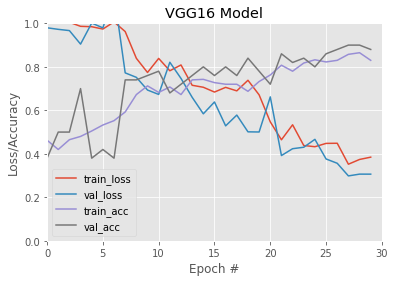

[INFO] evaluating VGG16 model...
              precision    recall  f1-score   support

       covid       1.00      0.62      0.77         8
      normal       0.79      0.96      0.87        24
   pneumonia       0.88      0.78      0.82        18

    accuracy                           0.84        50
   macro avg       0.89      0.79      0.82        50
weighted avg       0.86      0.84      0.84        50

[[ 5  2  1]
 [ 0 23  1]
 [ 0  4 14]]
Evaluation Runtime 0.3977835178375244 Seconds

-----------------------------------------------------------



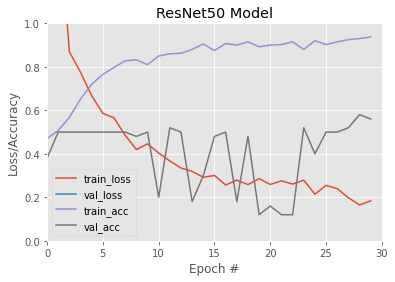

[INFO] evaluating ResNet50 model...
              precision    recall  f1-score   support

       covid       0.20      0.38      0.26         8
      normal       0.00      0.00      0.00        24
   pneumonia       0.49      0.94      0.64        18

    accuracy                           0.40        50
   macro avg       0.23      0.44      0.30        50
weighted avg       0.21      0.40      0.27        50

[[ 3  0  5]
 [11  0 13]
 [ 1  0 17]]
Evaluation Runtime 0.3723011016845703 Seconds

-----------------------------------------------------------



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


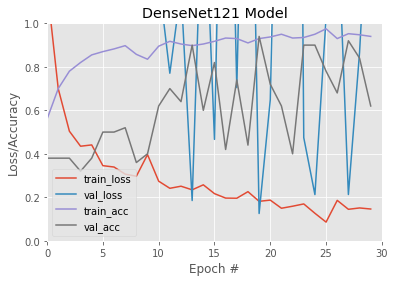

[INFO] evaluating DenseNet121 model...
              precision    recall  f1-score   support

       covid       0.55      0.75      0.63         8
      normal       0.67      0.92      0.77        24
   pneumonia       0.67      0.22      0.33        18

    accuracy                           0.64        50
   macro avg       0.63      0.63      0.58        50
weighted avg       0.65      0.64      0.59        50

[[ 6  2  0]
 [ 0 22  2]
 [ 5  9  4]]
Evaluation Runtime 0.7091188430786133 Seconds

-----------------------------------------------------------



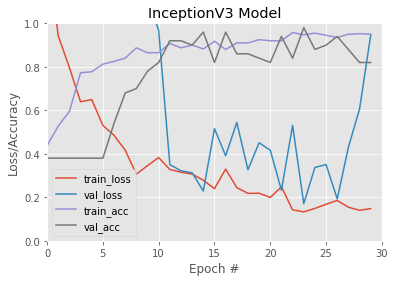

[INFO] evaluating InceptionV3 model...
              precision    recall  f1-score   support

       covid       1.00      0.50      0.67         8
      normal       0.72      0.96      0.82        24
   pneumonia       0.93      0.72      0.81        18

    accuracy                           0.80        50
   macro avg       0.88      0.73      0.77        50
weighted avg       0.84      0.80      0.79        50

[[ 4  4  0]
 [ 0 23  1]
 [ 0  5 13]]
Evaluation Runtime 0.36969637870788574 Seconds

-----------------------------------------------------------



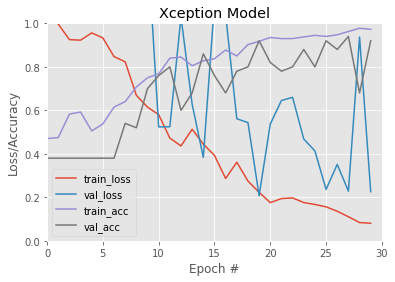

[INFO] evaluating Xception model...
              precision    recall  f1-score   support

       covid       1.00      0.75      0.86         8
      normal       0.95      0.83      0.89        24
   pneumonia       0.78      1.00      0.88        18

    accuracy                           0.88        50
   macro avg       0.91      0.86      0.87        50
weighted avg       0.90      0.88      0.88        50

[[ 6  1  1]
 [ 0 20  4]
 [ 0  0 18]]
Evaluation Runtime 0.38068580627441406 Seconds

-----------------------------------------------------------



In [ ]:
evaluate(VGG16_model, 'VGG16', VGG16_H)
evaluate(ResNet50_model, 'ResNet50', ResNet50_H)
evaluate(DenseNet121_model, 'DenseNet121', DenseNet121_H)
evaluate(InceptionV3_model, 'InceptionV3', InceptionV3_H)
evaluate(Xception_model, 'Xception', Xception_H)

## Hyperparameters Selection - (Pending)

In [ ]:
def create_model(baseModel, INIT_LR, BS, decay, name):
  # initialize the training data augmentation object
  trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(64, activation="relu")(headModel)
  headModel = Dense(3, activation="softmax")(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)

  # *not* be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  print(f'{name} Models is Ready')

  print("compiling model...")

  opt = Adam(lr=INIT_LR, decay=decay)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

  print('Compiling Completed')

  # tensorboard setup
  NAME = '{}-{}'.format(name, int(time.time()))
  tensorboard = TensorBoard(log_dir='/content/drive/My Drive/Covid Thesis/logs_new/{}'.format(NAME),update_freq='batch')

  # train the head of the network
  print("training the model...")
  model_H = model.fit(trainAug.flow(trainX, trainY, batch_size=BS),
                            steps_per_epoch=len(trainX) // BS,
                            validation_data=(valX, valY),
                            validation_steps=len(valX) // BS,
                            epochs=EPOCHS,
                            callbacks=[tensorboard])
  
  # Save the model
  model.save('/content/drive/My Drive/Covid Thesis/models_new/{}.h5'.format(name))

  print(f"[INFO] evaluating {name} model...\n INIT_LR: {INIT_LR},\tBS: {BS},\tdecay: {decay}\n")
  predIdxs = model.predict(testX, batch_size=BS)
  predIdxs = np.argmax(predIdxs, axis=1)
  CR = classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_)
  CM = confusion_matrix(testY.argmax(axis=1), predIdxs)
  print(CR)
  print(CM)

  return {'Name':name,'LR': INIT_LR,'BS': BS,'decay': decay,'CR':CR,'CM':CM}


In [ ]:
EPOCHS = 1
df = pd.DataFrame(columns=['Name', 'LR', 'BS','decay', 'CR', 'CM'])
df_List = []
model_version = 1

for i in range(5):
  for j in range(1,5):
    INIT_LR = float(f'1e-{i}')
    BS = 8*j
    myModel = create_model(DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))), INIT_LR, BS, INIT_LR / EPOCHS, 'DenseNet_v{}'.format(model_version))
    df_List.append(myModel)
    model_version+=1


DenseNet_v1 Models is Ready
compiling model...
Compiling Completed
training the model...
208/250 [=======================>......] - ETA: 3s - loss: 7.5458 - accuracy: 0.2596

KeyboardInterrupt: ignored